In [11]:
from time import sleep
import pickle
import os
import shutil
from collections import Counter
from threading import Thread
import queue
from tqdm.auto import tqdm
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torch.utils.data import DataLoader, Dataset
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics.pairwise import cosine_similarity
import plotly.graph_objects as go
from sklearn.metrics.pairwise import cosine_similarity

from src.utils import load_model, get_dataloaders, load_images_in_folder, show_images, modify_keys, save_results, transforms
from src.center_loss import CenterLoss
from arc_face import FocalLoss, SphereProduct, ArcMarginProduct, AdaCos
from src.train import train_model

In [12]:
lr = 0.0001
batch_size = 32
num_epochs = 80

TRAIN_PATH = '/mnt/hdd/1/imageData/train/russianDataCleanAdded'
TEST_PATH = '/mnt/hdd/1/imageData/index/russianDataCleanAdded'
num_classes = len(os.listdir(TRAIN_PATH))
    
state_path = 'state_arcface.pkl'
model_name = 'arcfaceloss'

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

datasets, dataloaders = get_dataloaders(TRAIN_PATH, TEST_PATH, batch_size)

cuda:0


In [13]:
class ArcFace(nn.Module):
    def __init__(self):
        super(ArcFace, self).__init__()
        self.model = torchvision.models.resnet50(pretrained=True)
        in_features = self.model.fc.in_features
        self.model.fc = nn.Sequential(nn.Linear(in_features, 512), 
                                      nn.ReLU(),
                                      nn.Dropout(0.4),
                                     )
        s=30.0
        margin=0.50
        ls_eps=0.0
        theta_zero=0.785
        self.sphere = ArcMarginProduct(512, num_classes,
                                       s=s, m=margin, easy_margin=False, ls_eps=ls_eps)
#         self.sphere = AdaCos(512, num_classes, m=margin, theta_zero=theta_zero)
        
    def __call__(self, x, label):
        y = self.model(x)
        return y, self.sphere(y, label)
    
    def check_predictions(self, dataloader):
        ys = []
        pred = []
        with torch.no_grad():
            for x, y in tqdm(dataloader):
                output = self(x.to(device), y.to(device))
                pred.append(torch.argmax(output, dim=1))
                ys.extend(y)
        correct = {}
        pred = torch.cat(pred).cpu()

        for y, p in zip(ys, pred.cpu()):
            correct[y.item()] = correct.get(y.item(), np.array([0, 0])) + np.array([y == p, 1])
        return accuracy_score(ys, pred), correct
        
    def confusion_matrix(self, dataloader):
        ys = []
        pred = []
        with torch.no_grad():
            for x, y in dataloader:
                output = self(x.to(device))
                pred.append(torch.argmax(output, dim=1))
                ys.extend(y)
        return confusion_matrix(ys, torch.cat(pred).cpu())
    
    def predictions_for_class(self, x):
        with torch.no_grad():
            output = self(x.to(device))
            return torch.sort(torch.softmax(output.cpu(), dim=1), dim=1)
    

In [4]:
model = ArcFace().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()
# train_loss, val_loss = train_model(dataloaders, device, model, criterion, optimizer, state_path, model_name, num_epochs=num_epochs,
#                                   continue_train=True, arcface=True)

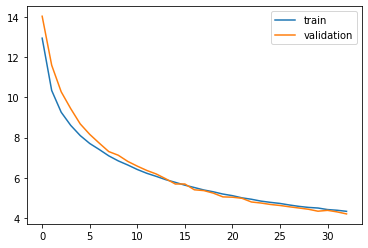

In [14]:
with open(state_path, 'rb') as f:
    state = pickle.load(f)
train_loss = state['loss']
val_loss = state['val_losses']

plt.plot(np.arange(len(train_loss)), train_loss)
plt.plot(np.arange(len(val_loss)), val_loss)
plt.legend(('train', 'validation'));

In [15]:
state['accuracy']

[0.15472819437161336,
 0.28725747246984795,
 0.3590980597797588,
 0.41545184408320224,
 0.4623317601817864,
 0.5119035133717882,
 0.5380178290508653,
 0.5590281419332285,
 0.5772766998776437,
 0.6045446600244713,
 0.6197517916448173,
 0.6408320223737108,
 0.6490823282642895,
 0.6637650760356582,
 0.6778185631882538,
 0.6813494144380353,
 0.6970110120608285,
 0.6969061352910331,
 0.7106100332109772,
 0.7136514595350463,
 0.7183709141758434,
 0.7226708617374585,
 0.734976402726796,
 0.734976402726796,
 0.7385072539765776,
 0.7446949833945115,
 0.74759657402552,
 0.7510575074287712,
 0.7565110994581367,
 0.7643768571927985,
 0.765775214123405,
 0.7665443104352386,
 0.7722426149274603]

In [16]:
epoch = 32 #48
model2 = ArcFace().to(device)
model2 = load_model(model2, model_name, epoch) #'moredata_centerloss'
model2.eval();

In [9]:
def calc_centroids(model, loader, path='models/centers_arcface.pkl'):
#     if os.path.exists(path):
#         with open(path, 'rb') as f:
#             return pickle.load(f)
    centers = np.zeros((num_classes, 512))
    cnt = np.zeros(num_classes)
    for x, y in tqdm(loader):
        feat, _ = model(x.to(device), y.to(device))
        centers[y] += feat.detach().cpu().numpy()
        cnt[y] += 1
        
    for i in range(num_classes):
        centers[i] /= (cnt[i] + 0.0000001)
    centers = centers[:-1]
    with open(path, 'wb') as f:
        pickle.dump(centers, f)
        
    return centers


centers = calc_centroids(model2, dataloaders['train'])

In [17]:
def check_classes(a, b):
    datasets['train'].classes

def centroid_test(loader):
    correct = 0
    for x, y in tqdm(loader):
        features, _ = model2(x.to(device), y.to(device))
        for xx, yy in zip(features, y):
            d = cosine_similarity(centers, 
                                  xx.detach().cpu().reshape(1, -1)).reshape(-1)
            if d.argmax() == yy:
                correct += 1
            
    return correct

res = centroid_test(dataloaders['test']) 

In [19]:
res / len(datasets['test'])

0.8504457262716308